Лабораторная работа № 4. Сети с радиальными базисными элементами

Выполнил: Степанов Данила Михайлович

Группа: М8О-407Б-20

Вариант: 22

Цель работы

Целью работы является исследование свойств некоторых видов сетей с радиальными базисными элементами, алгоритмов обучения, а также применение сетей в задачах классификации и
аппроксимации функции.

Решение

In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split

In [ ]:
hidden_size = 4

x = torch.tensor([[1,2],
                  [3,4],
                  [5,6]])

x = x.unsqueeze(1).repeat(1, hidden_size, 1) # n x k x 2
x

tensor([[[1, 2],
         [1, 2],
         [1, 2],
         [1, 2]],

        [[3, 4],
         [3, 4],
         [3, 4],
         [3, 4]],

        [[5, 6],
         [5, 6],
         [5, 6],
         [5, 6]]])

Напишем функцию для генерации точек

In [ ]:
def generate_points(count, a, b):
  X = [random.uniform(-a, a) for i in range(count)]
  points = [(x, (b / a) * (random.randint(0,1)*2-1) * np.sqrt(a ** 2 - x ** 2)) for x in X]
  return points

Сгенерируем данные и отобразим им

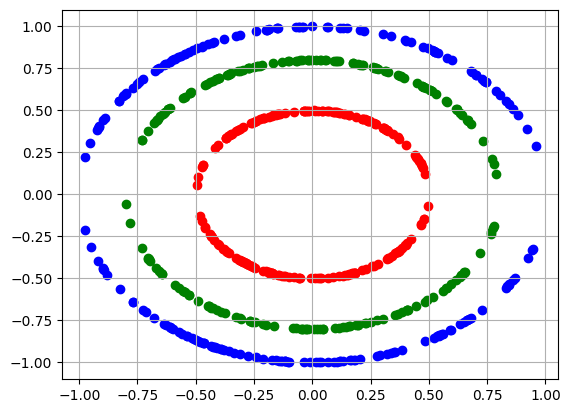

In [ ]:
points1 = generate_points(200, 0.5, 0.5)
points2 = generate_points(200, 0.8, 0.8)
points3 = generate_points(200, 1, 1)
x1 = [p[0] for p in points1]
y1 = [p[1] for p in points1]
x2 = [p[0] for p in points2]
y2 = [p[1] for p in points2]
x3 = [p[0] for p in points3]
y3 = [p[1] for p in points3]

plt.scatter(x1, y1, c="red")
plt.scatter(x2, y2, c="green")
plt.scatter(x3, y3, c="blue")
plt.grid(True)

Создадим вероятностную нейронную сеть

In [ ]:
class PNN:
  def __init__(self, std):
    self.std = std

  def fit(self, X_train, y_train):
    self.X_train = X_train
    self.y_train = y_train

  def predict(self, X):
    train_size = self.X_train.shape[0]
    test_size = X.shape[0]
    variance = self.std ** 2
    y = np.argmax(self.y_train, axis=1)
    const = self.std * np.sqrt(2 * np.pi)
    pattern_values = np.zeros((train_size, test_size))
    for i, sample in enumerate(X):
      samples = np.tile(sample, (train_size, 1))
      diffs_for_sample = samples - self.X_train
      dist_for_samples = np.sum(diffs_for_sample * diffs_for_sample, axis=1)
      values = np.exp(-dist_for_samples / variance) / const
      pattern_values[:, i] = values

    preds = np.zeros(test_size)

    for i in range(test_size):
      mean_values = [[] for unique_y in np.unique(y)]
      values = [mean_values[y].append(value) for value, y in zip(pattern_values[:, i], y)]
      mean_values = list(map(np.mean, mean_values))
      preds[i] = np.argmax(mean_values)

    return preds

Создадим выборку данных

In [ ]:
def create_data(size1, size2, size3, tensors=False):
  points1 = generate_points(size1, 0.5, 0.5)
  points2 = generate_points(size2, 0.8, 0.8)
  points3 = generate_points(size3, 1, 1)
  size = size1 + size2 + size3
  labels = np.reshape(np.array([1, 0, 0] * size1 + [0, 1, 0] * size2 + [0, 0, 1] * size3), (size, 3))
  data = np.array(points1 + points2 + points3)
  if tensors:
    return torch.tensor(data, dtype=torch.float), torch.tensor(labels, dtype=torch.float)
  else:
    return data, labels

Создадим выборку и разделим её на обучающую и тестовую

In [ ]:
X, y = create_data(100, 100, 100)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

In [ ]:
def acc(y_real, y_pred):
  return (np.array(y_real == y_pred)).sum() / y_real.shape[0]

Обучим модель и оценим на тестовом множестве

In [ ]:
model = PNN(0.3)
model.fit(X_train, y_train)
preds = model.predict(X_test)
y_test_ = np.argmax(y_test, axis=1)
print("test acc: ", acc(y_test_, preds))

test acc:  0.95


Создадим сеть с радиально-базисными элементами

In [ ]:
class RBFNetwork(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super().__init__()
    self.input_size = input_size
    self.output_size = output_size
    self.lin1 = nn.Linear(input_size, input_size)
    self.lin2 = nn.Linear(hidden_size, output_size)
    self.hidden_size = hidden_size
    self.mean = nn.Parameter(torch.tensor(np.random.uniform(size=(hidden_size, input_size)), dtype=torch.float))
    self.sigma = nn.Parameter(torch.tensor(np.random.uniform(size=hidden_size), dtype=torch.float))

  def forward(self, x):
    x = self.lin1(x)
    x = x.unsqueeze(1).repeat(1, self.hidden_size, 1)
    mean_weights = torch.tile(self.mean, (x.shape[0], 1, 1))
    const_value = 2 * self.sigma ** 2
    diff = (x - mean_weights) ** 2
    dist = torch.sum(diff, dim=2)
    pattern_values = torch.exp(dist / const_value)
    outputs = self.lin2(pattern_values)
    return outputs


In [ ]:
X, y = create_data(100, 100, 100, tensors=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

Опишем функцию для обучения сети

In [ ]:
def train(model, X, y, criterion, optimizer, epochs=10):
  model.train()
  history = []
  for epoch in range(epochs):
    acc = 0.0
    optimizer.zero_grad()
    outputs = model(X)
    preds = torch.argmax(outputs, dim=1)
    true_values = torch.argmax(y, dim=1)
    acc = (preds == true_values).sum() / X.shape[0]
    loss = criterion(outputs, true_values)
    history.append(loss.item())
    if epoch % 1000 == 0:
      print("epoch=", epoch, " loss: ", loss.item(), "acc: ", round(acc.item(), 3))
    loss.backward()
    optimizer.step()

  return history

def eval(model, X, y):
  model.eval()
  outputs = model(X)
  preds = torch.argmax(outputs, dim=1)
  true_values = torch.argmax(y, dim=1)
  acc = (preds == true_values).sum() / X.shape[0]
  print("test acc: ", acc.item())

Опишем всё необходимое для обучения сети: модель, функцию потерь и оптимизатор

In [ ]:
epochs = 3000

model = RBFNetwork(2, 2, 3)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())
history = train(model, X_train, y_train, criterion, optimizer, epochs=epochs)

epoch= 0  loss:  5.277644634246826 acc:  0.35
epoch= 1000  loss:  1.090815782546997 acc:  0.387
epoch= 2000  loss:  1.0882278680801392 acc:  0.408


Отобразим кривую обучения

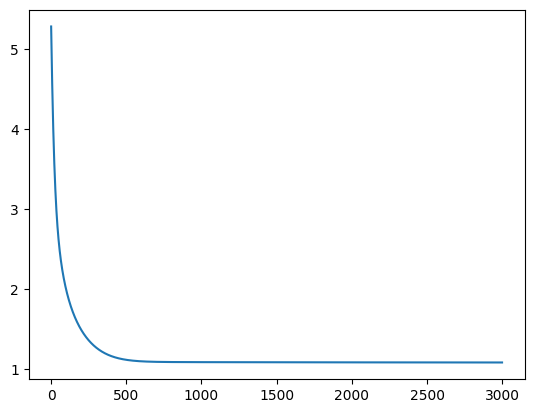

In [ ]:
plt.plot(range(epochs), history)

Оценим качество на тестовом наборе

In [ ]:
eval(model, X_test, y_test)

test acc:  0.9666666388511658


Создадим обобщённо-регрессионную модель

In [ ]:
class GRNN:
  def __init__(self, std):
    self.std = std

  def fit(self, X_train, y_train):
    self.X_train = X_train
    self.y_train = y_train

  def predict(self, X):
    train_size = self.X_train.shape[0]
    test_size = X.shape[0]
    variance = self.std ** 2
    y = self.y_train
    const = self.std * np.sqrt(2 * np.pi)
    pattern_values = np.zeros((train_size, test_size))

    for i, sample in enumerate(X):
      samples = np.tile(sample, (train_size, 1))
      diffs_for_sample = samples - self.X_train
      dist_for_samples = np.sum(diffs_for_sample * diffs_for_sample, axis=1)
      values = np.exp(-dist_for_samples / variance) / const
      pattern_values[:, i] = values

    preds = np.zeros(test_size)

    for i in range(test_size):
      kernel_values = pattern_values[:, i]
      pred = [value * y for value, y in zip(kernel_values, y)]
      preds[i] = sum(pred) / sum(kernel_values)

    return preds


Определим функцию для аппроксимацию и функцию для генерации обучающих данных

In [ ]:
x = lambda t: np.sin(-np.sin(t) * t ** 2 + t)

def generate_samples(f, start, finish, step):
    samples_size = int((finish - start) / step) # число элементов в выборке(объекты)
    t = [start + step * i for i in range(samples_size + 1)] # генерируем аргументы функции(предсказания на объектах)
    labels = [x(t) for t in t] # значения аппроксимируемой функции в точках множества t
    X = np.reshape(np.array(t), (samples_size + 1, 1)) # создаём из аргументов тензор для обучения
    y = np.reshape(np.array(labels), (samples_size + 1, 1)) # создаём из предсказаний тензор для обучения
    return X, y

X, y = generate_samples(x, 0.5, 4.0, 0.01)

Обучим модель и получим её предсказания на обучающей выборке

In [ ]:
model = GRNN(0.01)
model.fit(X, y)
preds = model.predict(X)

Опишем функцию для сравнения исходной функции и полученной аппроксимации

In [ ]:
def compare_functions(target_function, model, X, y, a, b, size):
  outputs = preds
  plt.plot(np.linspace(a, b, size), y, c="red")
  plt.plot(np.linspace(a, b, size), outputs)
  plt.legend(["Исходная функциия", "Аппроксимация функции"])

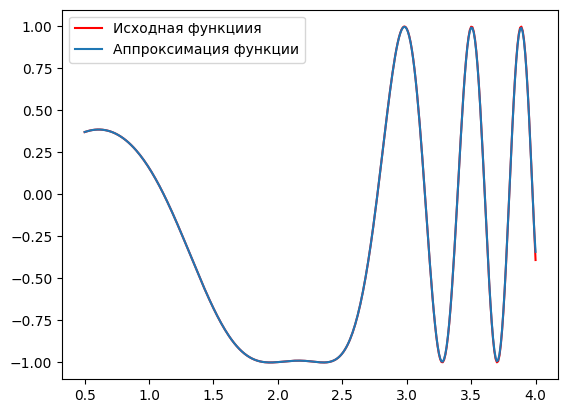

In [ ]:
compare_functions(x, model, X, y, 0.5, 4.0, 351)

Вывод:

Сети с радиальными базисными функциями используют расстояние между входными объектами и эталонными значениями для расчёта степени сходства с обучающими примерами, чтобы определить вероятность принадлежности к классу или рассчитать прогнозируемое значение. Так модели отлично подходят для решения нелинейных задач, будь то аппкросимация функции или разделение линейно неразделимых точек.